# Surgery

Move all the weight and biases from MikeNet to TensorFlow

In [1]:
from mnutil import MikeNetWeight
mn_weight = MikeNetWeight("Reading_Weight_v10")

print('\nShapes of weights:')
mn_weight.shape_map

Weight Keys: ['Phono -> psh', 'Con -> csh', 'psh -> Semantics', 'csh -> Semantics', 'Semantics -> SemCleanup', 'SemCleanup -> Semantics', 'Bias -> Semantics', 'Bias -> SemCleanup', 'Bias -> psh', 'Bias -> csh', 'Semantics -> sph', 'sph -> Phono', 'Phono -> PhoCleanup', 'PhoCleanup -> Phono', 'Bias -> Phono', 'Bias -> sph', 'Bias -> PhoCleanup', 'Ortho -> oph', 'Ortho -> osh', 'oph -> Phono', 'osh -> Semantics', 'Bias -> oph', 'Bias -> osh']

Non-weight Keys: ['SimulatorSeed 114806242', 'TAOS Phono', 'DELAYS Phono', 'TAOS psh', 'DELAYS psh', 'TAOS sph', 'DELAYS sph', 'TAOS Semantics', 'DELAYS Semantics', 'TAOS SemCleanup', 'DELAYS SemCleanup', 'TAOS PhoCleanup', 'DELAYS PhoCleanup', 'TAOS Bias', 'DELAYS Bias', 'TAOS Ortho', 'DELAYS Ortho', 'TAOS oph', 'DELAYS oph', 'TAOS osh', 'DELAYS osh', 'TAOS Con', 'DELAYS Con', 'TAOS csh', 'DELAYS csh']


2021-11-12 20:14:04.496277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 20:14:04.535801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 20:14:04.536355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 20:14:04.537910: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate


Shapes of weights:


{'Phono -> psh': (200, 300),
 'psh -> Semantics': (300, 2446),
 'Semantics -> SemCleanup': (2446, 50),
 'SemCleanup -> Semantics': (50, 2446),
 'Semantics -> sph': (2446, 300),
 'sph -> Phono': (300, 200),
 'Phono -> PhoCleanup': (200, 50),
 'PhoCleanup -> Phono': (50, 200),
 'Ortho -> oph': (364, 500),
 'Ortho -> osh': (364, 500),
 'oph -> Phono': (500, 200),
 'osh -> Semantics': (500, 2446),
 'Bias -> oph': (500,),
 'Bias -> osh': (500,),
 'Bias -> Semantics': (2446,),
 'Bias -> Phono': (200,),
 'Bias -> psh': (300,),
 'Bias -> sph': (300,),
 'Bias -> SemCleanup': (50,),
 'Bias -> PhoCleanup': (50,)}

# Create config file

In [2]:
code_name = "surgery"
batch_name = None
tf_root = "/home/jupyter/triangle_model"

# Model configs
ort_units = 364
pho_units = 200
sem_units = 2446
hidden_os_units = 500
hidden_op_units = 500
hidden_ps_units = 300
hidden_sp_units = 300
pho_cleanup_units = 50
sem_cleanup_units = 50
pho_noise_level = 0.
sem_noise_level = 0.
activation = "sigmoid"

tau = 1 / 3
max_unit_time = 4.0
output_ticks = 13
inject_error_ticks = 11

### Parameter below doesn't matter, because we don't train the model

# Training configs
learning_rate = 0.005
zero_error_radius = 0.1
save_freq = 20

# Environment configs
task_names = ["pho_sem", "sem_pho", "pho_pho", "sem_sem", "ort_pho", "ort_sem", "triangle"]
wf_compression = "log"
wf_clip_low = 0
wf_clip_high = 999_999_999
oral_start_pct = 1.0
oral_end_pct = 1.0

total_sample = 1_800_000
tasks_ps = (0.2, 0.2, 0.05, 0.05, .1, .1, .3)

batch_size = 100
rng_seed = 2021

## Build TF model

In [3]:
import meta, modeling
cfg = meta.Config.from_dict(**globals())
model = modeling.TriangleModel(cfg)
model.build()

UUID not found, regenerating.
Saved config json to /triangle_model/models/surgery/model_config.json


# Grafting

In [4]:
import tensorflow as tf

for weight in model.weights:
    try:
        name = weight.name[:-2]
        weight.assign(mn_weight.weights_tf[name])
        print(f"Grafted {name} from mikenet to TensorFlow")

        # Post-load weight sanity check
        tf.debugging.assert_equal(mn_weight.weights_tf[name], weight)

    except KeyError:
        print(f"Missing weight {name} in mikenet")
        pass

Grafted w_hsp_sh from mikenet to TensorFlow
Grafted w_hsp_hp from mikenet to TensorFlow
Grafted w_pc from mikenet to TensorFlow
Grafted w_cp from mikenet to TensorFlow
Grafted bias_hsp from mikenet to TensorFlow
Grafted bias_p from mikenet to TensorFlow
Grafted bias_cpp from mikenet to TensorFlow
Grafted w_hps_ph from mikenet to TensorFlow
Grafted w_hps_hs from mikenet to TensorFlow
Grafted w_sc from mikenet to TensorFlow
Grafted w_cs from mikenet to TensorFlow
Grafted bias_hps from mikenet to TensorFlow
Grafted bias_s from mikenet to TensorFlow
Grafted bias_css from mikenet to TensorFlow
Grafted w_hos_oh from mikenet to TensorFlow
Grafted w_hos_hs from mikenet to TensorFlow
Grafted bias_hos from mikenet to TensorFlow
Grafted w_hop_oh from mikenet to TensorFlow
Grafted w_hop_hp from mikenet to TensorFlow
Grafted bias_hop from mikenet to TensorFlow


### Check mean

In [5]:
[print(f'{w.name} mean: {w.numpy().mean()}') for w in model.weights]

w_hsp_sh:0 mean: -0.036436256021261215
w_hsp_hp:0 mean: -0.15658600628376007
w_pc:0 mean: -0.09082742780447006
w_cp:0 mean: -0.38210487365722656
bias_hsp:0 mean: -2.535120964050293
bias_p:0 mean: -3.783306837081909
bias_cpp:0 mean: -2.9965076446533203
w_hps_ph:0 mean: -0.14618974924087524
w_hps_hs:0 mean: -0.18353353440761566
w_sc:0 mean: -0.03645188361406326
w_cs:0 mean: -0.3741818368434906
bias_hps:0 mean: -2.2887043952941895
bias_s:0 mean: -3.3815836906433105
bias_css:0 mean: -1.3210525512695312
w_hos_oh:0 mean: -0.048883236944675446
w_hos_hs:0 mean: -0.0537002868950367
bias_hos:0 mean: -3.338172197341919
w_hop_oh:0 mean: -0.032783929258584976
w_hop_hp:0 mean: -0.09362849593162537
bias_hop:0 mean: -2.79338002204895


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

[None]

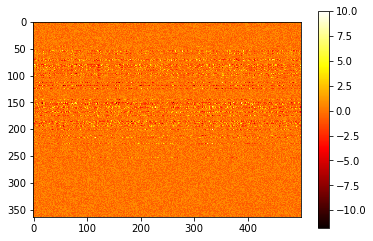

In [8]:
# Re-Double check the weights looks like what we put in
import matplotlib.pyplot as plt

def my_heatmap(x):
    plt.imshow(x, cmap='hot', interpolation='none')
    plt.colorbar()

[my_heatmap(w) for w in model.weights if w.name.startswith("w_hop_oh")]

### Save grafted weights model into TF checkpoint format

In [9]:
ckpt = tf.train.Checkpoint(model=model)

ckpt_manager = tf.train.CheckpointManager(
    ckpt,
    cfg.checkpoint_folder,
    max_to_keep=None,  # Keep all checkpoints
    checkpoint_name="epoch",
)

ckpt_manager.save(1)

'/triangle_model/models/surgery/checkpoints/epoch-1'